In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [1]:
! pip install autopep8

  Using cached autopep8-1.5.2.tar.gz (117 kB)
     |████████████████████████████████| 41 kB 263 kB/s eta 0:00:01
  Created wheel for autopep8: filename=autopep8-1.5.2-py2.py3-none-any.whl size=43754 sha256=bc6f06053a013a5037ae9a89f4002aed482b9980e048d483580a93af44509501
  Stored in directory: /Users/levan/Library/Caches/pip/wheels/db/03/ca/c1f69122ce37565af2598e1dbd535df75b4d52247a6d69ed0f
Successfully built autopep8


## Install FastAI V2

In [1]:
! pip install -U fastai2

  Using cached https://files.pythonhosted.org/packages/26/4f/0f61bb0d376eb47c20430639bac4946ca0cffcd7e693fb86698656324f2d/fastai2-0.0.17-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/dd/f3/8cd2e1ed981b0ddbe4d56e5d44f52c9e56d27ac7d53c30abb534d10c82c2/fastcore-0.1.17-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a3/da/ffd8fe0daf7e679804a32a1e8654ac2988e2ef85937fc1d223e98eee736e/fastprogress-0.2.3-py3-none-any.whl
     |████████████████████████████████| 440kB 537kB/s eta 0:00:01
ERROR: fastai 1.0.58 requires nvidia-ml-py3, which is not installed.
ERROR: fastai 1.0.58 requires pynvx>=1.0.0, which is not installed.
ERROR: torchvision 0.6.0 has requirement torch==1.5.0, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: fastprogress 0.1.21
    Uninstalling fastprogress-0.1.21:
      Successfully uninstalled fastprogress-0.1.21
  Found existing installation: torchvision 0.4.1a0+d94043a
    Uninstalling torchvis

## Import fastAI v2 vision modules

In [2]:
from fastai2.vision.all import *

## Semantic segmentation with UNet model

Recall the UNet model:
<img src="images/od/unet.png" height="800" width="800">

Download the dataset.
#### Note Here I'll download the "tiny" version, but you should switch it with 
```python
untar_data(URLs.CAMVID)
```

In [4]:
path = untar_data(URLs.CAMVID_TINY)

Let's look into the data

In [5]:
path.ls()

(#3) [Path('/Users/levan/.fastai/data/camvid_tiny/images'),Path('/Users/levan/.fastai/data/camvid_tiny/labels'),Path('/Users/levan/.fastai/data/camvid_tiny/codes.txt')]

In [7]:
(path / 'images').ls()

(#100) [Path('/Users/levan/.fastai/data/camvid_tiny/images/0006R0_f02550.png'),Path('/Users/levan/.fastai/data/camvid_tiny/images/0016E5_08137.png'),Path('/Users/levan/.fastai/data/camvid_tiny/images/0001TP_006840.png'),Path('/Users/levan/.fastai/data/camvid_tiny/images/0001TP_008070.png'),Path('/Users/levan/.fastai/data/camvid_tiny/images/0016E5_08057.png'),Path('/Users/levan/.fastai/data/camvid_tiny/images/0001TP_009150.png'),Path('/Users/levan/.fastai/data/camvid_tiny/images/Seq05VD_f03660.png'),Path('/Users/levan/.fastai/data/camvid_tiny/images/Seq05VD_f01260.png'),Path('/Users/levan/.fastai/data/camvid_tiny/images/0016E5_06090.png'),Path('/Users/levan/.fastai/data/camvid_tiny/images/0016E5_06870.png')...]

In [8]:
(path / 'labels').ls()

(#100) [Path('/Users/levan/.fastai/data/camvid_tiny/labels/Seq05VD_f02070_P.png'),Path('/Users/levan/.fastai/data/camvid_tiny/labels/0001TP_009000_P.png'),Path('/Users/levan/.fastai/data/camvid_tiny/labels/Seq05VD_f02640_P.png'),Path('/Users/levan/.fastai/data/camvid_tiny/labels/Seq05VD_f03150_P.png'),Path('/Users/levan/.fastai/data/camvid_tiny/labels/0006R0_f03630_P.png'),Path('/Users/levan/.fastai/data/camvid_tiny/labels/0006R0_f02550_P.png'),Path('/Users/levan/.fastai/data/camvid_tiny/labels/0006R0_f03240_P.png'),Path('/Users/levan/.fastai/data/camvid_tiny/labels/0001TP_009360_P.png'),Path('/Users/levan/.fastai/data/camvid_tiny/labels/Seq05VD_f01320_P.png'),Path('/Users/levan/.fastai/data/camvid_tiny/labels/0016E5_08400_P.png')...]

Load the class codes:

In [10]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:
fnames = get_image_files(path/"images")
fnames[0]

Path('/Users/levan/.fastai/data/camvid_tiny/images/0006R0_f02550.png')

In [12]:
?? get_image_files

Initialize labels

In [14]:
def label_func(fn): 
    return path/"labels"/f"{fn.stem}_P{fn.suffix}"

Initialize the data loader

In [50]:
dls = SegmentationDataLoaders.from_label_func(path, bs=8, fnames=fnames, label_func=label_func, codes=codes, 
                                              seed=2020)

Look into the actual images

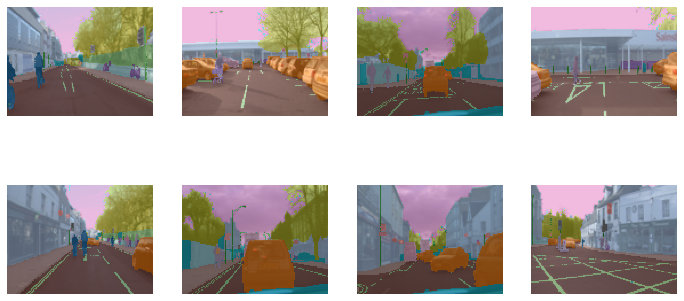

In [22]:
dls.show_batch(max_n=8)

## Initialize the model

In [23]:
learn = unet_learner(dls, resnet34)

Look in the model

In [24]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

Recall pixel-suffle up-sumpling layer:
<img src="images/od/pixel_shuffle_1.jpg" height="1000" width="1000">

Where are the concatenations?
<br/>
For this FastAi library uses so called runtime hooks

In [29]:
print(learn.__dict__)

{'init_args': {'Learner.__init__.loss_func': None, 'Learner.__init__.lr': 0.001, 'Learner.__init__.splitter': <function _resnet_split at 0x13bce2430>, 'Learner.__init__.metrics': None, 'Learner.__init__.path': None, 'Learner.__init__.model_dir': 'models', 'Learner.__init__.wd': None, 'Learner.__init__.wd_bn_bias': False, 'Learner.__init__.train_bn': True, 'Learner.__init__.moms': (0.95, 0.85, 0.95), 'unet_learner.arch': <function resnet34 at 0x13b92a3a0>, 'unet_learner.loss_func': None, 'unet_learner.pretrained': True, 'unet_learner.cut': None, 'unet_learner.splitter': None, 'unet_learner.config': None, 'unet_learner.n_in': 3, 'unet_learner.n_out': None, 'unet_learner.normalize': True, 'unet_learner.lr': 0.001, 'unet_learner.metrics': None, 'unet_learner.path': None, 'unet_learner.model_dir': 'models', 'unet_learner.wd': None, 'unet_learner.wd_bn_bias': False, 'unet_learner.train_bn': True, 'unet_learner.moms': (0.95, 0.85, 0.95)}, 'dls': <fastai2.data.core.DataLoaders object at 0x13d6

Check the optimizer

In [30]:
learn.opt_func

<function fastai2.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

Check the loss function:

In [35]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [38]:
?? FlattenedLoss

Object ` FlattenedLoss` not found.


Check the type

In [36]:
type(learn.loss_func)

fastai2.layers.CrossEntropyLossFlat

In [40]:
?? CrossEntropyLossFlat

In [41]:
?? BaseLoss

In [42]:
learn.fine_tune(8)

TraitError: Unexpected error in TraitType: default value not set properly

Check the results

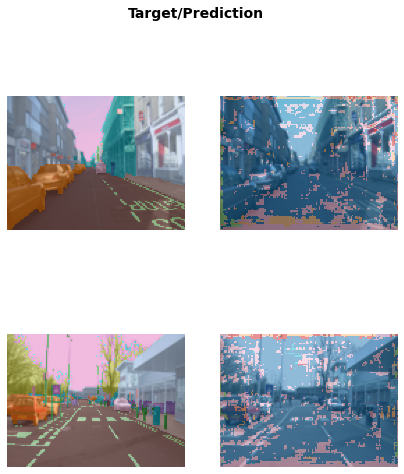

In [43]:
learn.show_results(max_n=6, figsize=(7, 8))

#### Use data block API for image loading

In [44]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(120,160)))

In [45]:
dls = camvid.dataloaders(path/"images", path=path, bs=8)

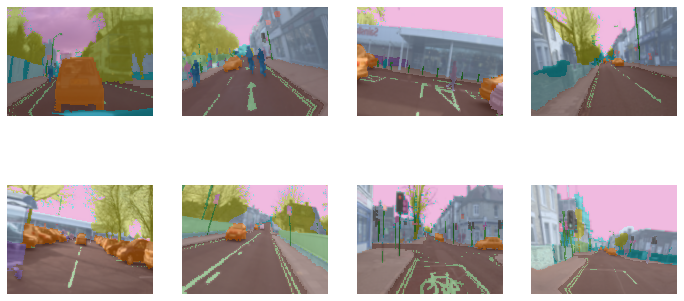

In [46]:
dls.show_batch(max_n=8)

In [47]:
?? get_image_files

In [48]:
?? get_files

## Find learning rate

In [49]:
learn.lr_find()

RuntimeError: DataLoader worker (pid(s) 54445) exited unexpectedly

fine-tuning means it will update all layers weights and biases with discriminative learning rate

In [51]:
?? learn.fine_tune

#### Task: Try train with different size (progressive growing) and different augmentations